In [1]:
import os
import cv2
import time
import json
import pickle
import numpy as np
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
from cnn import SegmentationModel as net

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print('Torch:' + torch.__version__)
print('Opencv:' + cv2.__version__)

cuda
Torch:1.1.0
Opencv:4.1.1


In [3]:
def bb_iou(boxes1, boxes2):
    x11, y11, x12, y12 = np.split(boxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(boxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

In [4]:
def colorir(cat):
    h, w = cat.shape[:2]
    msk = np.zeros((h,w,3), dtype = 'uint8')
    msk[cat == 1] = [0,255,0]
    msk[cat == 2] = [0,0,255]
    return(msk)

In [5]:
def get_bboxes(contours, minArea, maxArea, minDst, maxDst):
    bboxes = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        bbox = cv2.boundingRect(cnt)
        x,y,w,h = np.array(bbox)
        if area >  minArea and area < maxArea:
            if (x > minDst) and ((x+w) < maxDst):
                bboxes.append([x,y,x+w,y+h])
    return(np.array(bboxes))

In [6]:
def transform(x):
    x = x.copy()
    x = x.astype('float')
    x -= 128
    x /= 35
    x = np.moveaxis(x, 2, 0)
    x = x[np.newaxis]
    x = torch.from_numpy(x)
    x = Variable(x).to(device, dtype=torch.float)
    return(x)

In [7]:
def get_cat(frame):
    img = transform(frame)
    pred, feat = model(img)
    pred = pred.cpu().data.numpy()
    pred = np.moveaxis(pred, 1, 3)
    pred = np.squeeze(pred)
    cat = np.argmax(pred, 2).astype('uint8')
    return(cat)

In [8]:
n_classes = 3

# Atribui o modelo
model = net.EESPNet_Seg(n_classes, s=0.5, pretrained='', gpus=1)
model = model.to(device)
model.load_state_dict(torch.load('../data/Trackingff.pth',map_location=device))


# set to evaluation mode
model.eval()

print('Modelo Ok')

Modelo Ok


In [9]:
frames_dir = '/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Plantas/'
msks_dir = '/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Pred/'
video_dir = '/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Videos/'


In [10]:
input_height = 1080
input_width = 1920

output_height = 384
output_width = 512

ioh, iow = input_height/output_height, input_width/output_width
iocv = np.array([iow, ioh, iow, ioh])

video_files = sorted(os.listdir(video_dir))
video_files = [os.path.join(video_dir, v) for v in video_files if not v.endswith(('.json', '_bb.avi'))]

font = cv2.FONT_HERSHEY_SIMPLEX  
ini_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
  

In [11]:
print(video_files)
iocv

['/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Videos/20190726.avi']


array([3.75  , 2.8125, 3.75  , 2.8125])

In [12]:
for vid in range(len(video_files)):
    video_file = video_files[vid]
    save_file = video_file.replace('.avi', '_bb.avi')
    json_file = save_file.replace('.avi', '.json')

    out = cv2.VideoWriter(save_file, fourcc, 30.0, (output_width, output_height))
    print(save_file)

    old_plant_boxes = new_plant_boxes = tmp_plant_boxes = np.array([]) # inicialize the boxes vector
    old_stem_boxes = new_stem_boxes = tmp_stem_boxes = np.array([])
    video_history = {}

    n_plantas = 1 # counter
    n_frames = 1
    speed = 25 
    last_speed = speed
    speed_avg = speed * np.ones(10)
    
    
    cap = cv2.VideoCapture(video_file)
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#   n_frames = 75
    t_start = time.time()                 
    for i in range(n_frames):
        print(i)
        start_time = time.time()
        res, frameo = cap.read()
        frame = cv2.resize(frameo, (output_width, output_height))
        cv2.imwrite(msks_dir + 'F{:04d}.jpg'.format(i), frame)
        
        cat = get_cat(frame)
       
        # apply the overlay
        alpha = 0.5
        pred = colorir(cat)
        mskf = np.zeros_like(cat)
        framec = cv2.resize(pred, (output_width, output_height))
        cv2.addWeighted(framec, alpha, frame, 1 - alpha, 0, frame)
    
        
        # Cria duas mascaras, a primeira para planta + tubete e a segunda apenas do tubete:
        plant_msk = (cat > 0).astype('uint8')
        stem_msk = (cat == 2).astype('uint8')
        
        # Aplica um kernel vertical, para evitar que existam interrupcoes no contorno das plantas,
        # o que causaria a existencia de dois bbox:
        plant_msk = cv2.dilate(plant_msk, ini_kernel, iterations = 15)
        stem_msk = cv2.dilate(stem_msk, ini_kernel, iterations = 5)
        
        # Encontra os bbox das plantas com tubetes, que depois eh enconlhido para ficar soh a planta:
        contours, hierarchy = cv2.findContours(plant_msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        new_plant_boxes = get_bboxes(contours, 5000, 500000, 10, 500)
        
        # Encontra os bbox dos tubetes, que depois sao movidos para a posicao do caule:
        contours, hierarchy = cv2.findContours(stem_msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        new_stem_boxes = get_bboxes(contours, 100, 10000, 10, 500) 
        
        if new_plant_boxes.size > 0:
            # Ordena os bbox pelo eixo x, para que o primeiro fique a direita e o ultimo a esquerda:
            new_plant_boxes = new_plant_boxes[new_plant_boxes[:,0].argsort()[::-1]]
            
            # Define um criterio para os bbox que estao apenas na primeira metade do video:
            mcrit = np.ones(len(new_plant_boxes), dtype=bool)
#             mcrit[new_plant_boxes[:,0] < 10] = False
#             mcrit[new_plant_boxes[:,2] > frame.shape[1]/2] = False

            # Se ja existem bbox anteriores, atualiza com os correspondentes:
            if old_plant_boxes.size > 0 :
                areas = bb_iou(new_plant_boxes, old_plant_boxes)
                ncrit = np.where(areas.max(0) > 0)
                acrit = areas.argmax(0)[ncrit]
                old_plant_boxes[ncrit] = new_plant_boxes[acrit]
                mcrit[acrit] = False
            
            # Armazena os bbox nao correspondentes, eles seram avaliados ao final e incluidos se forem validos:
            tmp_plant_boxes = new_plant_boxes[mcrit]
                
        
        if new_stem_boxes.size > 0:
            # Ordena os bbox pelo eixo x, para que o primeiro fique a direita e o ultimo a esquerda:
            new_stem_boxes = new_stem_boxes[new_stem_boxes[:,0].argsort()[::-1]]       
            
            # Define um criterio para os bbox que estao apenas na primeira metade do video:
            mcrit = np.ones(len(new_stem_boxes), dtype=bool)
            mcrit[new_stem_boxes[:,0] < 10] = False
            mcrit[new_stem_boxes[:,2] > frame.shape[1]/2] = False
            
            # Se ja existem bbox anteriores, atualiza com os correspondentes:
            if old_stem_boxes.size > 0 :
                areas = bb_iou(new_stem_boxes, old_stem_boxes)
                ncrit = np.where(areas.max(0) > 0)
                acrit = areas.argmax(0)[ncrit]        
                
                # Utiliza os bbox correspondentes para calcular a velocidade (px/frame):
                # Obs: O calculo ocorre aqui porque eh mais estavel calcular com base nos tubetes
                last_speed += np.mean(new_stem_boxes[acrit,0] - old_stem_boxes[ncrit,0])
                if last_speed > 0:
                    speed_avg = np.insert(speed_avg, 0, last_speed)[:10]
                    print("Speed:" + str(speed))
                else:
                    last_speed = speed
                speed = int(np.mean(speed_avg))
                old_stem_boxes[ncrit] = new_stem_boxes[acrit]
                mcrit[acrit] = False
            # Armazena os bbox nao correspondentes, eles seram avaliados ao final e incluidos se forem validos:
            tmp_stem_boxes = new_stem_boxes[mcrit]
                
        
        # Se for a primeira planta a ser identificada, atribui o bbox para plotar:
        if old_plant_boxes.size == 0 and old_stem_boxes.size == 0 :
            if tmp_plant_boxes.size > 0 and tmp_stem_boxes.size > 0 :
                old_stem_boxes = tmp_stem_boxes
                old_plant_boxes = tmp_plant_boxes
                tmp_stem_boxes = tmp_plant_boxes = np.array([])

            
        # Inicia o dicionario que vai salvar as coordendas dos dois bbox para cada planta:
        frame_str = {}
        if old_plant_boxes.size > 0 and old_stem_boxes.size > 0 :
            # Garante que os bbox da planta e do caule sao da mesma planta (intersectam):
            areas = bb_iou(old_plant_boxes, old_stem_boxes)
            nidx = areas.argmax(1)
                        
            for idx, ix in enumerate(nidx):
                sbb = old_stem_boxes[ix].copy()
                if areas.max(1)[idx] > 0 and (sbb[0] > 10) and (frame.shape[1] - sbb[2]) > 10:
                    
                    # Para cada bbox da planta realiza os ajustes na posicao, plota no frame e adiciona no dicionario:
                    bb = old_plant_boxes[idx].copy()
                    bb[3] = sbb[1] + 10
                    
                    mskf = cv2.rectangle(mskf,(bb[0], bb[1]), (bb[2], bb[3]),(1), -1)
                    mskf = cv2.rectangle(mskf,(bb[0], bb[1] + 30), (bb[2], bb[3]),(3), 5)
                    mskf = cv2.rectangle(mskf,(sbb[0], sbb[1]),(sbb[2], sbb[3]),(2), -1)
                    
                    plant_bb = np.int0(bb*iocv).tolist()
                    frame = cv2.rectangle(frame,(bb[0], bb[1]), (bb[2], bb[3]),(0,0,255), 2)
                    cv2.putText(frame, 'P{}'.format(idx + n_plantas),(int(np.mean(bb[[0,2]])), bb[1]), font, 1,(255,255,255),2,cv2.LINE_AA)

                    # Para cada bbox do caule realiza os ajustes na posicao, plota no frame e adiciona no dicionario:
                    xm = int(np.mean(sbb[[0,2]]))
                    sbb[[0,2]] = xm + np.array([-20,20])
                    sbb[[1,3]] = [sbb[1] - 10, sbb[1] + 10]                    
                    stem_bb = np.int0(sbb*iocv).tolist()
                    frame = cv2.rectangle(frame,(sbb[0], sbb[1]),(sbb[2], sbb[3]),(255,0,0), 2)
                    cv2.putText(frame, 'P{}'.format(idx + n_plantas),(xm, sbb[3]), font, 1,(255,255,255),2,cv2.LINE_AA)
                   
                    frame_str['P{}'.format(idx + n_plantas)] = {'Plant':plant_bb, 'Stem':stem_bb}


        # Adiciona ao dicionario do video as informacoes desse frame:
        video_history['Frame{:04d}'.format(i)] = frame_str
        frame_bbox = frame_str
        for p in frame_bbox.keys():
            f_bbox = frame_bbox.get(p)
            pbox = np.array(f_bbox.get('Plant'))
            pbox = np.int0(pbox)#*iocv)
            pbox[1] += 80               
            pbox[3] += 40               
            plantf_name = '_{}_F{:04d}.jpg'.format(p, i)
            plant_file = frames_dir + plantf_name
            cv2.imwrite(plant_file,frameo[pbox[1]:pbox[3], pbox[0]:pbox[2]])
        print(frame_str)
        
        # Nessa parte vou adicionar o outro modelo, que vai fazer a classificacao:
        # classificar(frame, planta)
        
        # Se existem novos bbox, adiciona ao conjunto que sera avaliado no proximo frame:
        if tmp_plant_boxes.size > 0 and tmp_stem_boxes.size > 0 and tmp_plant_boxes.size == tmp_stem_boxes.size:
            old_stem_boxes = np.concatenate([tmp_stem_boxes, old_stem_boxes])
            old_plant_boxes = np.concatenate([tmp_plant_boxes, old_plant_boxes])

        # Realiza a predicao da posicao de cada bbox no proximo frame, com base na velocidade instantanea:
        if old_plant_boxes.size > 0 and old_stem_boxes.size > 0 :
            old_stem_boxes += np.int0(last_speed * np.array([[1,0,1,0]]))
            old_stem_boxes = old_stem_boxes[old_stem_boxes[:,0].argsort()[::-1]]
            
            old_plant_boxes += np.int0(last_speed * np.array([[1,0,1,0]]))
            old_plant_boxes = old_plant_boxes[old_plant_boxes[:,0].argsort()[::-1]]
            
            # Remove os bbox que estarao fora da imagem, e conta como uma nova planta:
            # Obs: Esse sera o momento de enviar o controle com a classificacao da planta
            fcrit = old_stem_boxes[:,3] < frame.shape[1]
            if not fcrit.all():
                old_plant_boxes = old_plant_boxes[fcrit]
                old_stem_boxes = old_stem_boxes[fcrit]
                n_plantas += 1         
        
        cv2.imwrite(msks_dir + 'F{:04d}.png'.format(i), mskf)
        
        # Estou salvando apenas os frames com planta e movimento detectados:
        if last_speed > 10 and len(frame_str) > 0:
            out.write(frame)
        
        t_now = time.time()
        
        
        fps = i /(t_now - t_start)
        if i % 10 == 0:
            print('Running at {} FPS'.format(fps))
    
    cap.release()
    out.release()
    
    # Salva o dicionario em json com as informacoes desse video:
    with open(json_file, 'w') as outfile:
        json.dump(video_history, outfile)
        
    time_taken = time.time() - start_time
    print('PreProc time: %.2f' % time_taken)  



/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Videos/20190726_bb.avi
0
{}
Running at 0.0 FPS
1
{}
2
{}
3
{}
4
{}
5
{}
6
{}
7
{}
8
{}
9
{}
10
{}
Running at 8.493605956838437 FPS
11
{}
12
{}
13
{}
14
{}
15
{}
16
{}
17
{}
18
{}
19
{}
20
{}
Running at 12.946565488698967 FPS
21
{}
22
{}
23
{}
24
{}
25
{}
26
{}
27
{}
28
{}
29
{}
30
{}
Running at 15.630608729699507 FPS
31
{}
32
{}
33
{}
34
{}
35
{}
36
{}
37
{}
38
{}
39
{}
40
{}
Running at 17.125471015842667 FPS
41
{}
42
{}
43
{}
44
{}
45
{}
46
{}
47
{}
48
{}
49
{}
50
{}
Running at 18.368094278862817 FPS
51
{}
52
{}
53
{}
54
{}
55
{}
56
{}
57
{}
58
{}
59
{}
60
{}
Running at 19.281080213869327 FPS
61
{}
62
{}
63
{}
64
{}
65
{}
66
{}
67
{}
68
{}
69
{}
70
{}
Running at 19.92151121645401 FPS
71
{}
72
{}
73


/home/rodrigo7/.conda/envs/ANN/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rodrigo7/.conda/envs/ANN/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{}
74
{}
75
{}
76
{}
77
{}
78
Speed:25
{'P2': {'Plant': [116, 531, 502, 936], 'Stem': [191, 880, 341, 936]}}
79
Speed:23
{'P2': {'Plant': [180, 531, 506, 933], 'Stem': [225, 877, 375, 933]}}
80
Speed:22
{'P2': {'Plant': [183, 525, 506, 930], 'Stem': [277, 874, 427, 930]}}
Running at 20.29176735365536 FPS
81
Speed:21
{'P2': {'Plant': [165, 531, 521, 930], 'Stem': [322, 874, 472, 930]}}
82
Speed:19
{'P2': {'Plant': [180, 540, 573, 928], 'Stem': [367, 871, 517, 928]}}
83
Speed:18
{'P2': {'Plant': [187, 542, 615, 933], 'Stem': [405, 877, 555, 933]}}
84
Speed:16
{'P2': {'Plant': [210, 556, 663, 933], 'Stem': [468, 877, 618, 933]}}
85
Speed:16
{'P2': {'Plant': [225, 559, 686, 933], 'Stem': [510, 877, 660, 933]}}
86
Speed:14
{'P2': {'Plant': [273, 559, 723, 933], 'Stem': [551, 877, 701, 933]}}
87
Speed:13
{'P2': {'Plant': [300, 559, 783, 928], 'Stem': [596, 871, 746, 928]}}
88
{'P2': {'Plant': [348, 554, 810, 928], 'Stem': [600, 871, 750, 928]}}
89
Speed:11
{'P2': {'Plant': [438, 565, 870, 92

Speed:13
{'P4': {'Plant': [1518, 514, 1923, 928], 'Stem': [1672, 871, 1822, 928]}, 'P5': {'Plant': [326, 528, 686, 930], 'Stem': [506, 874, 656, 930]}}
169
Speed:13
{'P4': {'Plant': [1571, 514, 1976, 928], 'Stem': [1702, 871, 1852, 928]}, 'P5': {'Plant': [300, 525, 731, 928], 'Stem': [558, 871, 708, 928]}}
170
Speed:13
{'P4': {'Plant': [1608, 514, 2013, 928], 'Stem': [1740, 871, 1890, 928]}, 'P5': {'Plant': [273, 537, 768, 933], 'Stem': [588, 877, 738, 933]}}
Running at 21.415546797963867 FPS
171
Speed:12
{'P5': {'Plant': [270, 540, 795, 930], 'Stem': [630, 874, 780, 930]}}
172
Speed:12
{'P5': {'Plant': [337, 537, 843, 930], 'Stem': [671, 874, 821, 930]}}
173
Speed:12
{'P5': {'Plant': [322, 540, 888, 933], 'Stem': [716, 877, 866, 933]}}
174
Speed:12
{'P5': {'Plant': [393, 556, 922, 930], 'Stem': [750, 874, 900, 930]}}
175
Speed:11
{'P5': {'Plant': [461, 556, 982, 928], 'Stem': [813, 871, 963, 928]}}
176
Speed:12
{'P5': {'Plant': [551, 568, 1035, 925], 'Stem': [866, 869, 1016, 925]}}
17

Speed:12
{'P7': {'Plant': [1593, 551, 1901, 933], 'Stem': [1661, 877, 1811, 933]}}
245
Speed:11
{'P7': {'Plant': [1635, 551, 1942, 930], 'Stem': [1736, 874, 1886, 930]}}
246
{}
247
{}
248
{}
249
{}
250
Speed:12
{'P8': {'Plant': [228, 514, 618, 933], 'Stem': [405, 877, 555, 933]}}
Running at 21.132744667653785 FPS
251
Speed:12
{'P8': {'Plant': [318, 511, 678, 933], 'Stem': [450, 877, 600, 933]}}
252
Speed:12
{'P8': {'Plant': [427, 509, 768, 936], 'Stem': [510, 880, 660, 936]}}
253
Speed:12
{'P8': {'Plant': [498, 511, 851, 933], 'Stem': [543, 877, 693, 933]}}
254
Speed:12
{'P8': {'Plant': [551, 511, 918, 928], 'Stem': [581, 871, 731, 928]}}
255
Speed:12
{'P8': {'Plant': [585, 511, 971, 930], 'Stem': [630, 874, 780, 930]}}
256
Speed:12
{'P8': {'Plant': [641, 503, 1035, 930], 'Stem': [690, 874, 840, 930]}}
257
Speed:12
{'P8': {'Plant': [690, 495, 1076, 930], 'Stem': [723, 874, 873, 930]}}
258
Speed:12
{'P8': {'Plant': [727, 486, 1098, 928], 'Stem': [787, 871, 937, 928]}}
259
Speed:13
{'P8'

Speed:13
{'P10': {'Plant': [1605, 500, 2010, 922], 'Stem': [1642, 866, 1792, 922]}, 'P11': {'Plant': [371, 548, 765, 936], 'Stem': [480, 880, 630, 936]}}
334
Speed:13
{'P10': {'Plant': [1661, 500, 2066, 928], 'Stem': [1691, 871, 1841, 928]}, 'P11': {'Plant': [446, 548, 798, 933], 'Stem': [540, 877, 690, 933]}}
335
Speed:13
{'P10': {'Plant': [1717, 500, 2122, 928], 'Stem': [1747, 871, 1897, 928]}, 'P11': {'Plant': [487, 545, 851, 930], 'Stem': [573, 874, 723, 930]}}
336
Speed:13
{'P11': {'Plant': [540, 534, 911, 928], 'Stem': [626, 871, 776, 928]}}
337
Speed:13
{'P11': {'Plant': [585, 523, 945, 930], 'Stem': [667, 874, 817, 930]}}
338
Speed:13
{'P11': {'Plant': [622, 520, 997, 928], 'Stem': [693, 871, 843, 928]}}
339
Speed:12
{'P11': {'Plant': [648, 520, 1042, 928], 'Stem': [753, 871, 903, 928]}}
340
Speed:13
{'P11': {'Plant': [667, 514, 1080, 930], 'Stem': [806, 874, 956, 930]}}
Running at 21.428987603009908 FPS
341
Speed:13
{'P11': {'Plant': [716, 514, 1102, 928], 'Stem': [855, 871, 1

Speed:12
{'P14': {'Plant': [611, 528, 952, 930], 'Stem': [663, 874, 813, 930]}}
413
Speed:13
{'P14': {'Plant': [656, 523, 960, 930], 'Stem': [701, 874, 851, 930]}}
414
Speed:13
{'P14': {'Plant': [660, 517, 960, 928], 'Stem': [757, 871, 907, 928]}}
415
Speed:13
{'P14': {'Plant': [663, 520, 982, 928], 'Stem': [806, 871, 956, 928]}}
416
Speed:13
{'P14': {'Plant': [663, 523, 1016, 928], 'Stem': [847, 871, 997, 928]}}
417
Speed:13
{'P14': {'Plant': [678, 520, 1053, 925], 'Stem': [877, 869, 1027, 925]}}
418
Speed:12
{'P14': {'Plant': [708, 531, 1098, 928], 'Stem': [922, 871, 1072, 928]}}
419
Speed:13
{'P14': {'Plant': [742, 534, 1158, 930], 'Stem': [990, 874, 1140, 930]}}
420
Speed:13
{'P14': {'Plant': [787, 537, 1211, 930], 'Stem': [1035, 874, 1185, 930]}}
Running at 21.54508926252029 FPS
421
Speed:13
{'P14': {'Plant': [832, 531, 1233, 925], 'Stem': [1053, 869, 1203, 925]}}
422
Speed:13
{'P14': {'Plant': [922, 545, 1293, 930], 'Stem': [1110, 874, 1260, 930]}}
423
Speed:12
{'P14': {'Plant': 

KeyboardInterrupt: 

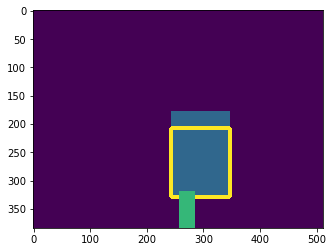

In [13]:
plt.imshow(mskf)

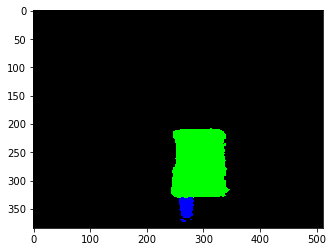

In [14]:
plt.imshow(pred)